## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Data Cleaning
### Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, probplot

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

unzip_data('zippedData/im.db.zip')

## Connect to sqlite3

path = 'im.db'

conn = sqlite3.connect(path)

In [3]:
#loading the csv files
bom = pd.read_csv('ZippedData/bom.movie_gross.csv')
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
# Drop Year
bom = bom.drop('year', axis=1)

In [5]:
query = 'SELECT * FROM movie_basics'
# Connect to SQLite database
im = pd.read_sql_query(query, conn)
im_df = pd.DataFrame(im)

im_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [6]:
# Drop original_title, start_year, and movie_id columns
columns_dropping = ['original_title', 'start_year', 'movie_id']
im_df = im_df.drop(columns=columns_dropping)

In [7]:
tmdb_movies = pd.read_csv('ZippedData/tmdb.movies.csv', index_col = 0)
tmdb_movies.head()

tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [8]:
# Unnamed, genre_ids,original_title, id
column_dropping = ['genre_ids', 'id', 'original_title']
tmdb_movies = tmdb_movies.drop(columns=column_dropping)

In [9]:
tn_movies_b = pd.read_csv('ZippedData/tn.movie_budgets.csv', index_col = 0)
tn_movies_b.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [10]:
tn_movies_b['movie'].nunique()

5698

In [11]:
# Identify duplicate movies in the 'movie' column
duplicate_movies = tn_movies_b[tn_movies_b['movie'].duplicated()]

duplicate_movies.head()


,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"
9,"Nov 21, 2018",Robin Hood,"$99,000,000","$30,824,628","$84,747,441"
85,"Jul 8, 2005",Fantastic Four,"$87,500,000","$154,696,080","$333,132,750"
44,"May 7, 1999",The Mummy,"$80,000,000","$155,385,488","$416,385,488"
8,"Jun 13, 1997",Hercules,"$70,000,000","$99,112,101","$250,700,000"


In [12]:
# Group by the 'movie' column and count occurrences, then filter for duplicates
duplicate_movie_counts = tn_movies_b['movie'].value_counts()
duplicate_movie_counts = duplicate_movie_counts[duplicate_movie_counts > 1]

duplicate_movie_counts

movie
Halloween                       3
Home                            3
King Kong                       3
Friday the 13th                 2
The Last House on the Left      2
                               ..
20,000 Leagues Under the Sea    2
The Gift                        2
Flatliners                      2
The Mummy                       2
Peteâs Dragon                 2
Name: count, Length: 81, dtype: int64

In [13]:
# Filter rows where the movie name is 'Godzilla'
godzilla_movies = tn_movies_b[tn_movies_b['movie'] == 'Halloween']

godzilla_movies

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
15,"Aug 31, 2007",Halloween,"$15,000,000","$58,269,151","$77,514,401"
36,"Oct 19, 2018",Halloween,"$10,000,000","$159,342,015","$254,900,667"
37,"Oct 17, 1978",Halloween,"$325,000","$47,000,000","$70,000,000"


#### Merging Data

In [14]:
# Perform an inner join on the title columns
merged_df = pd.merge(bom, im_df, left_on='title', right_on='primary_title', how='inner')
merged_df2 = pd.merge(merged_df, tmdb_movies, left_on='title', right_on='title', how='inner')
merged_df3 = pd.merge(merged_df2, tn_movies_b, left_on='title', right_on='movie', how='inner')



# Display the first few rows of the merged DataFrame
merged_df3.head()

,title,studio,domestic_gross_x,foreign_gross,primary_title,runtime_minutes,genres,original_language,popularity,release_date_x,vote_average,vote_count,release_date_y,movie,production_budget,domestic_gross_y,worldwide_gross
0,Toy Story 3,BV,415000000.0,652000000,Toy Story 3,103.0,"Adventure,Animation,Comedy",en,24.445,2010-06-17,7.7,8340,"Jun 18, 2010",Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522"
1,Inception,WB,292600000.0,535700000,Inception,148.0,"Action,Adventure,Sci-Fi",en,27.920,2010-07-16,8.3,22186,"Jul 16, 2010",Inception,"$160,000,000","$292,576,195","$835,524,642"
2,Shrek Forever After,P/DW,238700000.0,513900000,Shrek Forever After,93.0,"Adventure,Animation,Comedy",en,15.041,2010-05-16,6.1,3843,"May 21, 2010",Shrek Forever After,"$165,000,000","$238,736,787","$756,244,673"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,The Twilight Saga: Eclipse,124.0,"Adventure,Drama,Fantasy",en,20.340,2010-06-23,6.0,4909,"Jun 30, 2010",The Twilight Saga: Eclipse,"$68,000,000","$300,531,751","$706,102,828"
4,Iron Man 2,Par.,312400000.0,311500000,Iron Man 2,124.0,"Action,Adventure,Sci-Fi",en,28.515,2010-05-07,6.8,12368,"May 7, 2010",Iron Man 2,"$170,000,000","$312,433,331","$621,156,389"


In [15]:
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2097 non-null   object 
 1   studio             2097 non-null   object 
 2   domestic_gross_x   2096 non-null   float64
 3   foreign_gross      1751 non-null   object 
 4   primary_title      2097 non-null   object 
 5   runtime_minutes    1959 non-null   float64
 6   genres             2057 non-null   object 
 7   original_language  2097 non-null   object 
 8   popularity         2097 non-null   float64
 9   release_date_x     2097 non-null   object 
 10  vote_average       2097 non-null   float64
 11  vote_count         2097 non-null   int64  
 12  release_date_y     2097 non-null   object 
 13  movie              2097 non-null   object 
 14  production_budget  2097 non-null   object 
 15  domestic_gross_y   2097 non-null   object 
 16  worldwide_gross    2097 

In [16]:
column_dropping = ['primary_title', 'foreign_gross', 'original_language', 'release_date_y', 'domestic_gross_x']
merged_df3 = merged_df3.drop(columns = column_dropping)
merged_df3.head()

,title,studio,runtime_minutes,genres,popularity,release_date_x,vote_average,vote_count,movie,production_budget,domestic_gross_y,worldwide_gross
0,Toy Story 3,BV,103.0,"Adventure,Animation,Comedy",24.445,2010-06-17,7.7,8340,Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522"
1,Inception,WB,148.0,"Action,Adventure,Sci-Fi",27.920,2010-07-16,8.3,22186,Inception,"$160,000,000","$292,576,195","$835,524,642"
2,Shrek Forever After,P/DW,93.0,"Adventure,Animation,Comedy",15.041,2010-05-16,6.1,3843,Shrek Forever After,"$165,000,000","$238,736,787","$756,244,673"
3,The Twilight Saga: Eclipse,Sum.,124.0,"Adventure,Drama,Fantasy",20.340,2010-06-23,6.0,4909,The Twilight Saga: Eclipse,"$68,000,000","$300,531,751","$706,102,828"
4,Iron Man 2,Par.,124.0,"Action,Adventure,Sci-Fi",28.515,2010-05-07,6.8,12368,Iron Man 2,"$170,000,000","$312,433,331","$621,156,389"


In [17]:
# Droping rows with missing values
merged_df3.dropna(inplace=True)

In [18]:
# Droping the Duplicate rows
merged_df3.drop_duplicates(inplace=True)

In [19]:
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1764 non-null   object 
 1   studio             1764 non-null   object 
 2   runtime_minutes    1764 non-null   float64
 3   genres             1764 non-null   object 
 4   popularity         1764 non-null   float64
 5   release_date_x     1764 non-null   object 
 6   vote_average       1764 non-null   float64
 7   vote_count         1764 non-null   int64  
 8   movie              1764 non-null   object 
 9   production_budget  1764 non-null   object 
 10  domestic_gross_y   1764 non-null   object 
 11  worldwide_gross    1764 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 179.2+ KB


## Data Analysis

In [20]:
df = merged_df3.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1764 non-null   object 
 1   studio             1764 non-null   object 
 2   runtime_minutes    1764 non-null   float64
 3   genres             1764 non-null   object 
 4   popularity         1764 non-null   float64
 5   release_date_x     1764 non-null   object 
 6   vote_average       1764 non-null   float64
 7   vote_count         1764 non-null   int64  
 8   movie              1764 non-null   object 
 9   production_budget  1764 non-null   object 
 10  domestic_gross_y   1764 non-null   object 
 11  worldwide_gross    1764 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 179.2+ KB


In [22]:
# Removing currency symbols and commas, then converting to numeric
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df['domestic_gross_y'] = df['domestic_gross_y'].replace('[\$,]', '', regex=True).astype(float)
df['worldwide_gross'] = df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

In [23]:
df.describe()

,runtime_minutes,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
count,1764.000000,1764.000000,1764.000000,1764.000000,1.764000e+03,1.764000e+03,1.764000e+03
mean,102.873583,11.742131,6.266893,1919.866213,4.347379e+07,5.758016e+07,1.412417e+08
std,24.092100,8.125587,1.100051,2758.124577,5.410906e+07,8.443615e+07,2.274563e+08
min,3.000000,0.600000,0.000000,1.000000,5.000000e+04,0.000000e+00,0.000000e+00
25%,91.000000,7.516000,5.800000,231.000000,8.500000e+06,4.463292e+06,1.431204e+07
50%,102.000000,10.308000,6.300000,920.000000,2.500000e+07,3.097192e+07,6.032721e+07
75%,116.000000,14.802750,6.900000,2282.250000,5.040000e+07,7.139912e+07,1.591656e+08
max,192.000000,80.773000,10.000000,22186.000000,4.106000e+08,7.000596e+08,2.048134e+09


In [24]:
df.corr(numeric_only=True)

,runtime_minutes,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
runtime_minutes,1.000000,0.228878,0.199348,0.239648,0.218275,0.158339,0.187787
popularity,0.228878,1.000000,0.293032,0.681098,0.517353,0.484146,0.522407
vote_average,0.199348,0.293032,1.000000,0.340374,0.070867,0.154044,0.158699
vote_count,0.239648,0.681098,0.340374,1.000000,0.560976,0.685793,0.702576
production_budget,0.218275,0.517353,0.070867,0.560976,1.000000,0.692666,0.767890
domestic_gross_y,0.158339,0.484146,0.154044,0.685793,0.692666,1.000000,0.944452
worldwide_gross,0.187787,0.522407,0.158699,0.702576,0.767890,0.944452,1.000000


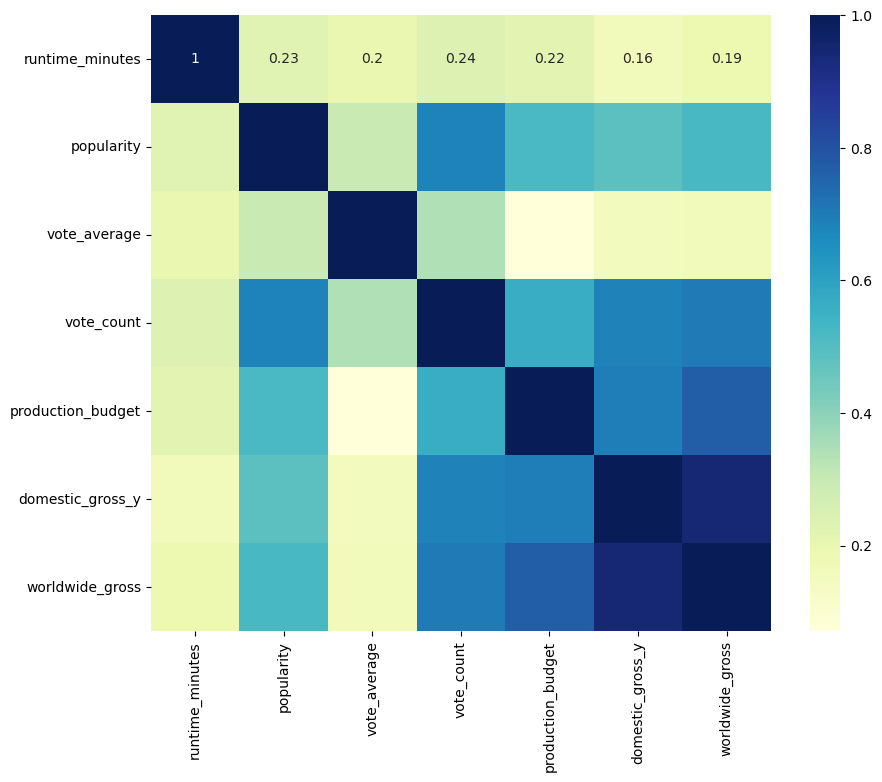

In [25]:
# Set figure size to make the plot larger
plt.figure(figsize=(10, 8))

# Plotting the correlation heatmap
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
plt.show()

In [26]:
df_numeric = df.select_dtypes(include = ['number'])
df_numeric.corr()

,runtime_minutes,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
runtime_minutes,1.000000,0.228878,0.199348,0.239648,0.218275,0.158339,0.187787
popularity,0.228878,1.000000,0.293032,0.681098,0.517353,0.484146,0.522407
vote_average,0.199348,0.293032,1.000000,0.340374,0.070867,0.154044,0.158699
vote_count,0.239648,0.681098,0.340374,1.000000,0.560976,0.685793,0.702576
production_budget,0.218275,0.517353,0.070867,0.560976,1.000000,0.692666,0.767890
domestic_gross_y,0.158339,0.484146,0.154044,0.685793,0.692666,1.000000,0.944452
worldwide_gross,0.187787,0.522407,0.158699,0.702576,0.767890,0.944452,1.000000


Text(0.5, 1.0, 'ScatterPlot on Correlation')

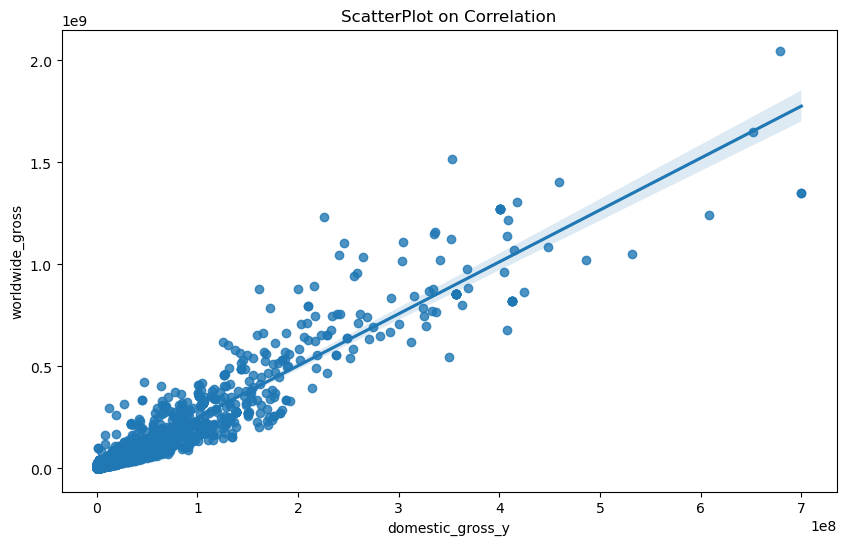

In [27]:
plt.figure(figsize = (10,6))

sns.regplot(data=df,x='domestic_gross_y',y='worldwide_gross')
plt.title('ScatterPlot on Correlation')

This scatter plot shows a strong positive correlation between domestic gross (x-axis) and worldwide gross (y-axis) for movies. As domestic gross increases, worldwide gross also tends to increase, indicating that movies performing well domestically often succeed globally. The trend line suggests a linear relationship, showing that domestic revenue is a good predictor of worldwide revenue.

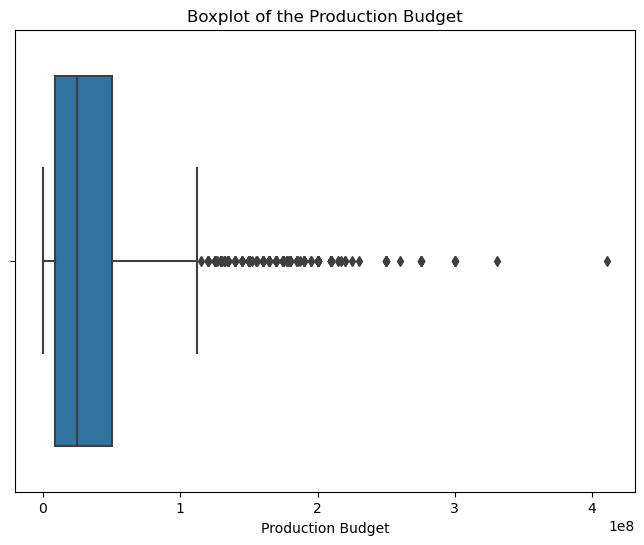

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='production_budget')
plt.xlabel('Production Budget')
plt.title('Boxplot of the Production Budget')
plt.show()

Text(0.5, 1.0, 'Distribution of the Runtime Minutes')

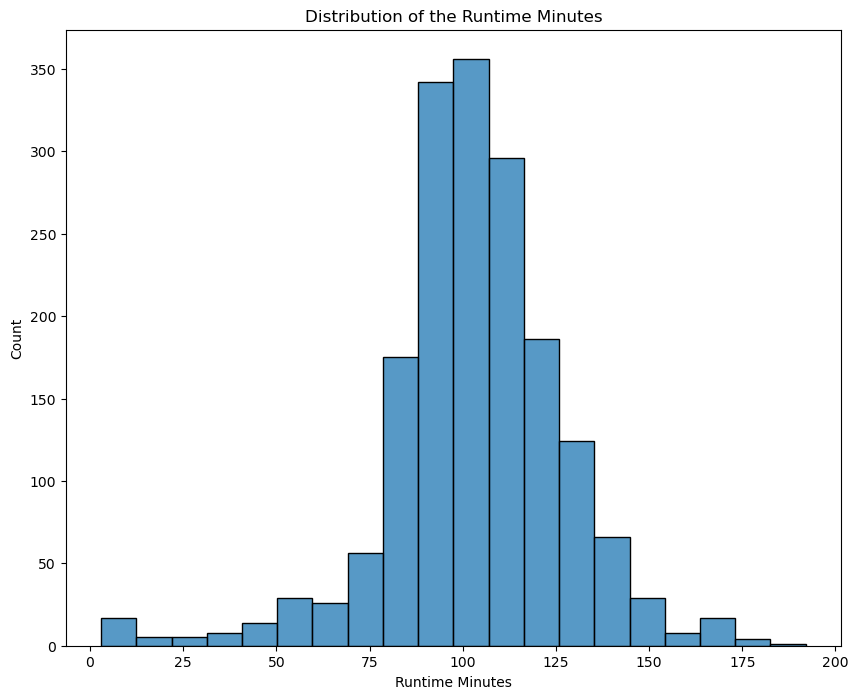

In [29]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='runtime_minutes',bins=20)
plt.xlabel('Runtime Minutes')
plt.title('Distribution of the Runtime Minutes')

The histogram shows that the distribution of the runtime minutes is normally distributed with mean of 100 minutes. This indicates that most movies have a runtime of 100 minutes.

Text(0.5, 1.0, 'Distribution of the Worldwide gross')

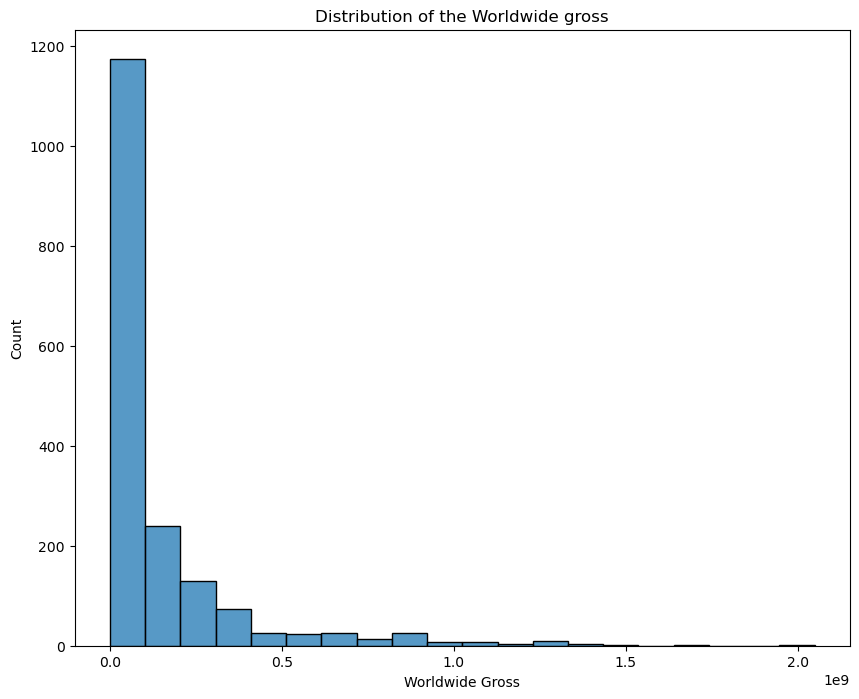

In [30]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='worldwide_gross',bins=20)
plt.xlabel('Worldwide Gross')
plt.title('Distribution of the Worldwide gross')

The distribution of the worldwide gross is skewed to the right. This indicates that most movies have relatively low worldwide gross revenues, while a few movies have very high revenues.

In [31]:
df['genres'].unique()

array(['Adventure,Animation,Comedy', 'Action,Adventure,Sci-Fi',
       'Adventure,Drama,Fantasy', 'Animation,Comedy,Family',
       'Action,Adventure,Animation', 'Adventure,Family,Fantasy',
       'Action,Drama,Family', 'Drama,Thriller', 'Action,Animation,Comedy',
       'Action,Adventure,Drama', 'Action,Drama',
       'Action,Adventure,Thriller', 'Action,Adventure,History',
       'Action,Adventure,Family', 'Comedy,Romance',
       'Action,Adventure,Horror', 'Mystery,Thriller',
       'Action,Mystery,Thriller', 'Comedy,Drama,Romance', 'Comedy',
       'Adventure,Drama,Western', 'Adventure,Comedy,Family',
       'Biography,Drama', 'Adventure,Comedy', 'Drama,Romance',
       'Biography,Documentary,Drama', 'Documentary,History', 'Drama',
       'Horror', 'Action,Comedy,Crime', 'Action,Thriller',
       'Biography,Documentary,History', 'Documentary', 'Action,Crime',
       'Crime,Drama,Thriller', 'Comedy,Crime,Romance',
       'Drama,Fantasy,Horror', 'Action,Comedy,Romance',
       'Biogr

In [32]:
# Split genres by comma, stack into a single column, and count each genre
genre_counts = df['genres'].str.split(',').explode().value_counts()

# Display the result
print(genre_counts)


genres
Drama          897
Comedy         508
Action         434
Adventure      336
Thriller       308
Crime          230
Romance        218
Horror         201
Biography      154
Mystery        132
Documentary    126
Sci-Fi         121
Fantasy        120
Animation      100
Family          88
History         64
Music           49
Sport           41
War             15
Western          8
Musical          5
News             2
Name: count, dtype: int64


In [33]:
listofgenre = df.loc[:,['genres']]

In [34]:
gen = listofgenre.stack().to_list()

In [35]:
from collections import defaultdict

# Step 1: Initialize a dictionary to hold genre counts
genre_counts = defaultdict(int)

# Step 2: Loop through each genre string, split it, and count each genre
for genres in gen:
    # Split the genres and strip any extra whitespace
    individual_genres = genres.split(',')
    for genre in individual_genres:
        genre = genre.strip()  # Ensure no leading/trailing whitespace
        genre_counts[genre] += 1

# Convert the defaultdict to a regular dictionary (optional)
genre_counts = dict(genre_counts)

# Display the result
print(genre_counts)

{'Adventure': 336, 'Animation': 100, 'Comedy': 508, 'Action': 434, 'Sci-Fi': 121, 'Drama': 897, 'Fantasy': 120, 'Family': 88, 'Thriller': 308, 'History': 64, 'Romance': 218, 'Horror': 201, 'Mystery': 132, 'Western': 8, 'Biography': 154, 'Documentary': 126, 'Crime': 230, 'Sport': 41, 'War': 15, 'Music': 49, 'Musical': 5, 'News': 2}


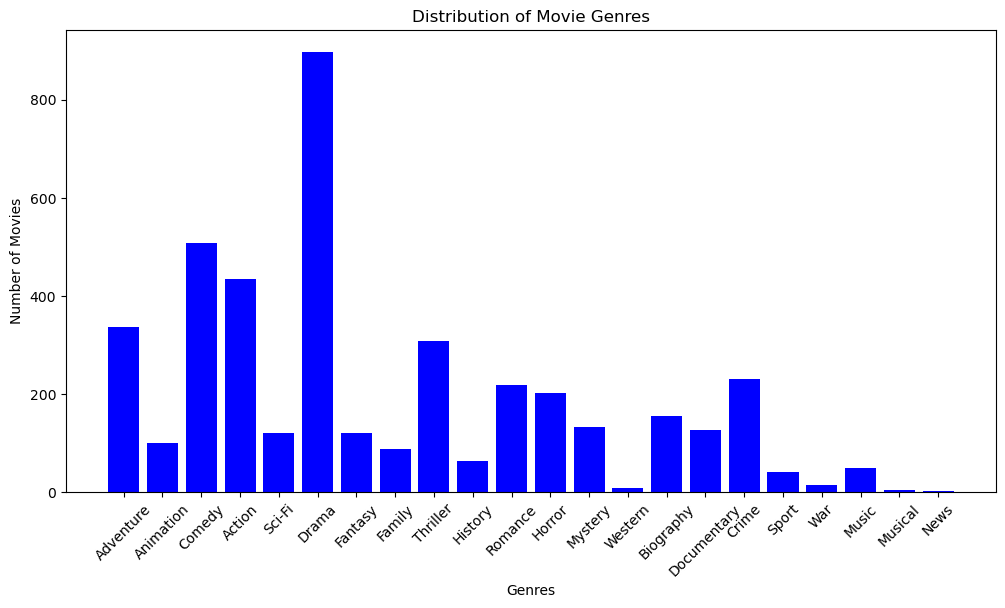

In [36]:
# Convert dictionary keys and values to lists for plotting
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Bar plot for genre counts
plt.figure(figsize=(12, 6))
plt.bar(genres, counts, color='blue')
plt.ylabel('Number of Movies')
plt.xlabel('Genres')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.show()

This graph indicates that Drama is the dominant genre, with Comedy and Action also being quite common. 

Genres like Western, War, Music, Musical, Sport, and News have the fewest movies, with very low counts compared to other genres. 

In [37]:
# Initialize a dictionary to hold lists of titles for each genre
genre_movies = defaultdict(list)

# Loop through each row in the DataFrame
for _, row in df.iterrows():
    # Split the genres in the current row
    row_genres = row["genres"].split(',')
    for genre in row_genres:
        genre = genre.strip()  # Remove any extra whitespace
        # Check if the genre exists in genre_counts and add the title to genre_movies
        if genre in genre_counts:
            genre_movies[genre].append(row["title"])

# Convert the defaultdict to a regular dictionary (optional)
genre_movies = dict(genre_movies)

# Display the result
print(genre_movies)

{'Adventure': ['Toy Story 3', 'Inception', 'Shrek Forever After', 'The Twilight Saga: Eclipse', 'Iron Man 2', 'Tangled', 'How to Train Your Dragon', 'The Chronicles of Narnia: The Voyage of the Dawn Treader', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'Robin Hood', 'The Last Airbender', 'Resident Evil: Afterlife', 'The Tourist', 'The Expendables', 'True Grit', "Gulliver's Travels", "The Sorcerer's Apprentice", 'Due Date', 'Yogi Bear', 'The A-Team', 'The Book of Eli', "Legend of the Guardians: The Owls of Ga'Hoole", 'Predators', 'Get Him to the Greek', 'Letters to Juliet', '127 Hours', 'The Losers', 'Ramona and Beezus', 'Centurion', 'The Runaways', 'Transformers: Dark of the Moon', 'Pirates of the Caribbean: On Stranger Tides', 'Kung Fu Panda 2', 'The Smurfs', 'Cars 2', 'Puss in Boots', 'Sherloc

In [38]:
genre_movies.keys()

dict_keys(['Adventure', 'Animation', 'Comedy', 'Action', 'Sci-Fi', 'Drama', 'Fantasy', 'Family', 'Thriller', 'History', 'Romance', 'Horror', 'Mystery', 'Western', 'Biography', 'Documentary', 'Crime', 'Sport', 'War', 'Music', 'Musical', 'News'])

In [39]:
genrate = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    # getting avg
    numeric_values = [float(value) for value in moviedata['vote_average']]
    avg = sum(numeric_values)/len(numeric_values)
    
    genrate.append({key:avg})
genrate

[{'Adventure': 6.3004545454545475},
 {'Animation': 5.934730538922154},
 {'Comedy': 6.1499316005472},
 {'Action': 6.150423011844331},
 {'Sci-Fi': 6.283428571428567},
 {'Drama': 6.3556876061120455},
 {'Fantasy': 6.007766990291261},
 {'Family': 6.424675324675323},
 {'Thriller': 5.905494505494491},
 {'History': 6.234899328859055},
 {'Romance': 6.390634441087611},
 {'Horror': 5.861671469740635},
 {'Mystery': 6.137339055793994},
 {'Western': 6.5625},
 {'Biography': 6.1608540925266855},
 {'Documentary': 6.185093167701865},
 {'Crime': 6.061052631578941},
 {'Sport': 6.36265060240964},
 {'War': 6.614814814814815},
 {'Music': 5.834545454545452},
 {'Musical': 6.828571428571428},
 {'News': 5.7}]

In [40]:
# Ensure columns are NumPy arrays and calculate ROI
roi = df['worldwide_gross'].values / df['production_budget'].values

# Convert the result back to a pandas Series and add to DataFrame
df['roi'] = pd.Series(roi, index=df.index)


In [41]:
genroi = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    # getting avg
    numeric_values = [float(value) for value in moviedata['roi']]
    avg = sum(numeric_values)/len(numeric_values)
    
    genroi.append({key:avg})

genroi

[{'Adventure': 3.0045202833808435},
 {'Animation': 3.1293460919523404},
 {'Comedy': 5.767990051504137},
 {'Action': 4.4122942189364505},
 {'Sci-Fi': 3.8978667966295077},
 {'Drama': 4.629671588699395},
 {'Fantasy': 8.209156093573254},
 {'Family': 2.2981695334530916},
 {'Thriller': 8.115149472876409},
 {'History': 2.824133994062624},
 {'Romance': 9.11984359245719},
 {'Horror': 12.520985644759671},
 {'Mystery': 7.8693375141998425},
 {'Western': 1.8406885466139071},
 {'Biography': 2.3833954890754536},
 {'Documentary': 3.6315817371633377},
 {'Crime': 1.9397726196823597},
 {'Sport': 15.233039176278428},
 {'War': 1.6772890173388362},
 {'Music': 2.4450009646300956},
 {'Musical': 4.242085786703773},
 {'News': 0.9834108591954023}]

In [42]:
genrevenue = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    
    # Calculate the sum of worldwide_gross
    total_gross = moviedata['worldwide_gross'].sum()
    
    # Calculate the average, avoiding division by zero
    avg = total_gross / len(moviedata['worldwide_gross']) 
    
    genrevenue.append({key: avg})


In [43]:
genrevenue

[{'Adventure': 326419611.9136364},
 {'Animation': 331265607.5508982},
 {'Comedy': 137036236.67715457},
 {'Action': 210305559.91539764},
 {'Sci-Fi': 283509837.30285716},
 {'Drama': 90048535.43039049},
 {'Fantasy': 209089373.76213592},
 {'Family': 148499158.75324675},
 {'Thriller': 103834366.0},
 {'History': 147613406.98657718},
 {'Romance': 96742630.65861027},
 {'Horror': 92038541.04899135},
 {'Mystery': 73983297.64377682},
 {'Western': 123227230.25},
 {'Biography': 92150745.19217081},
 {'Documentary': 106442756.36024845},
 {'Crime': 91816218.01052631},
 {'Sport': 241731808.9759036},
 {'War': 30669657.222222224},
 {'Music': 42549575.64545455},
 {'Musical': 112364960.14285715},
 {'News': 31657826.5}]

In [44]:
# Initialize a dictionary to combine values
combined_dict = {}

# Combine the first list of dictionaries
for entry in genrevenue:
    for key, value in entry.items():
        combined_dict[key] = [value]  # Start a new list for each genre

# Append the values from the second list of dictionaries
for entry in genrate:
    for key, value in entry.items():
        if key in combined_dict:
            combined_dict[key].append(value)  # Append to existing list

# Append the values from the third list of dictionaries
for entry in genroi:
    for key, value in entry.items():
        if key in combined_dict:
            combined_dict[key].append(value)  # Append to existing list

# Convert the combined dictionary into a DataFrame
combined_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in combined_dict.items()]))

# Transpose the DataFrame
transposed_df = combined_df.T

# Change column names
transposed_df.columns = ['genre_avg_gross', 'gen_avg_rating', 'gen_avg_roi']  # Assign new column names

# Optionally, reset the index to make the genre names a column
transposed_df.reset_index(inplace=True)

# Rename the index column for clarity
transposed_df.rename(columns={'index': 'Genre'}, inplace=True)

transposed_df = transposed_df.sort_values(by='gen_avg_roi', ascending=False)

# Display the transposed DataFrame
# transposed_df.to_csv('./genreAnalysis.csv')

In [45]:
transposed_df

,Genre,genre_avg_gross,gen_avg_rating,gen_avg_roi
17,Sport,2.417318e+08,6.362651,15.233039
11,Horror,9.203854e+07,5.861671,12.520986
10,Romance,9.674263e+07,6.390634,9.119844
6,Fantasy,2.090894e+08,6.007767,8.209156
8,Thriller,1.038344e+08,5.905495,8.115149
12,Mystery,7.398330e+07,6.137339,7.869338
2,Comedy,1.370362e+08,6.149932,5.767990
5,Drama,9.004854e+07,6.355688,4.629672
3,Action,2.103056e+08,6.150423,4.412294
20,Musical,1.123650e+08,6.828571,4.242086


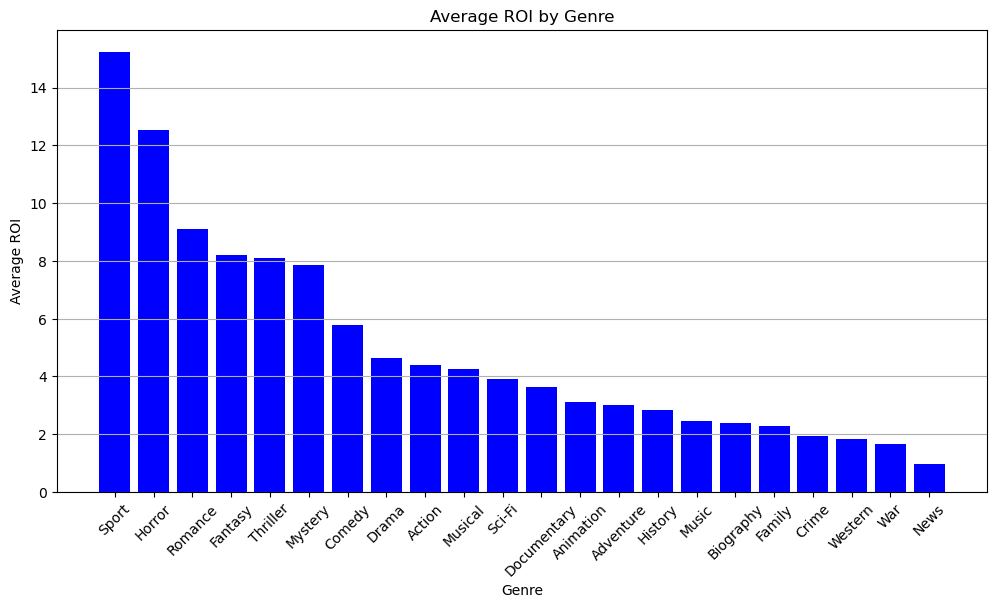

In [46]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(transposed_df['Genre'], transposed_df['gen_avg_roi'], color='blue')
plt.title('Average ROI by Genre')
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Sports, Horror, Romance, Fantacy and thriller genres have the highest average ROIs, suggesting that they tend to deliver better financial returns relative to their budgets. 

In contrast, genres like War, News, Western, and Crime have the lowest average ROIs, indicating comparatively lower profitability.

In [47]:
# Created a year variable from the release date 
df['year'] = pd.to_datetime(df['release_date_x']).dt.year

In [48]:
# budgets and revenue ,vote_count average rating
filter_data = df[df['year']>=2010]

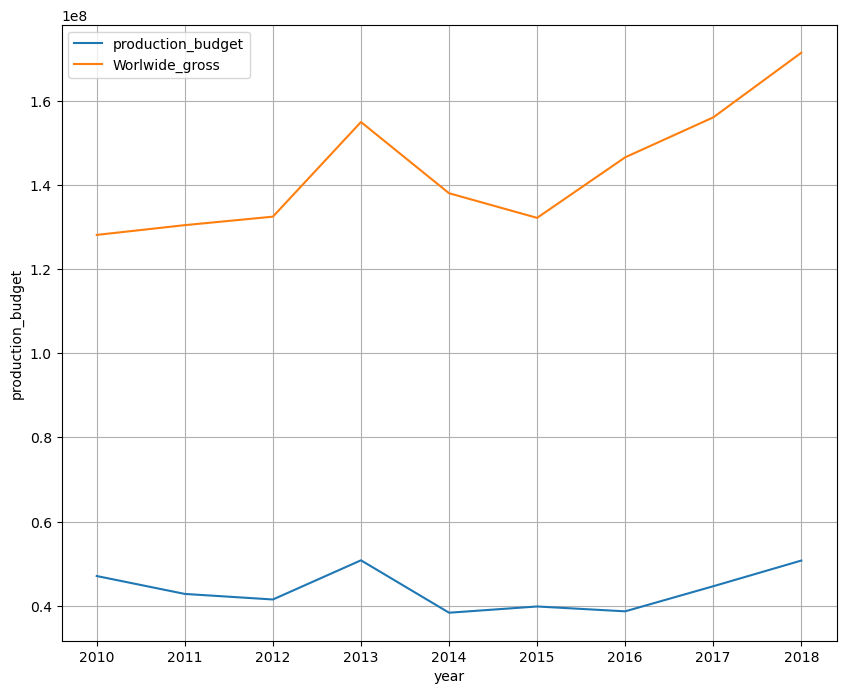

In [49]:
plt.figure(figsize=(10,8))
sns.lineplot(data=filter_data,x='year',y='production_budget',label='production_budget',ci=None)
sns.lineplot(data=filter_data,x='year',y='worldwide_gross',label='Worlwide_gross',ci=None)
# sns.lineplot()
plt.grid()

The line plot above compares production budgets and worldwide gross earnings over time from 2010 to 2018. The worldwide gross shows a generally upward trend, indicating that movies have been earning more globally over this period, especially notable increases around 2013, 2016, and 2018. In contrast, the production budget remains relatively stable with only slight fluctuations, suggesting that while budgets haven't increased significantly, worldwide revenue has grown, possibly reflecting improved profitability.

## Linear Regression

In [50]:
# Fit the model
X = df[['popularity', 'vote_average', 'production_budget', 'domestic_gross_y']]
X = sm.add_constant(X)  # Add a constant term to the predictor
y = df['worldwide_gross']
model = sm.OLS(y, X).fit()

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     4919.
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:17:16   Log-Likelihood:                -34241.
No. Observations:                1764   AIC:                         6.849e+04
Df Residuals:                    1759   BIC:                         6.852e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.693e+07   9.09e+06     -5.164      0.000   -6.48e+07   -2.91e+07
popularity         8.817e+05   2.38e+05      3.710      0.000    4.16e+05    1.35e+06
vote_average       2.923e+06   1.49e+06      1.961      0.050     -55.944    5.85e+06
production_budget     0.8765      0.042     20.896      0.000       0.794       0.959
domestic_gross_y      2.1082      0.026     80.572      0.000       2.057       2.159
==============================================================================
Omnibus:                      932.415   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19042.371
Skew:                           2.018   Prob(JB):                         0.00
Kurtosis:                      18.582   Cond. No.                     7.00e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  7e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Goodness of Fit Metrics

Rsquared - The model has an R-squared of 91.8%, thus the independent variables can explain 91.8% variation of the response variable.

Durbin Watson's statistic of 1.31 implies moderate positive autocorrelation in the residuals, which indicates that the model is not capturing all patterns in the data.

#### Coefficients

popularity, vote_average, production_budget, and domestic_gross_y are statistically significant in explaining worldwide_gross, since the p-values are less than 0.05

Popularity - With 1 unit increase in popularity, the worldwide gross increases by 8.817e+05

Vote Average - With 1 unit increase in vote average, the worldwide gross increases by  2.923e+06

Production Budget - With 1 unit increase in production budget, the worldwide gross increases by 0.8765

Domestic Gross - With 1 unit increase in Domestic Gross, the worldwide gross increases by 2.1082	000




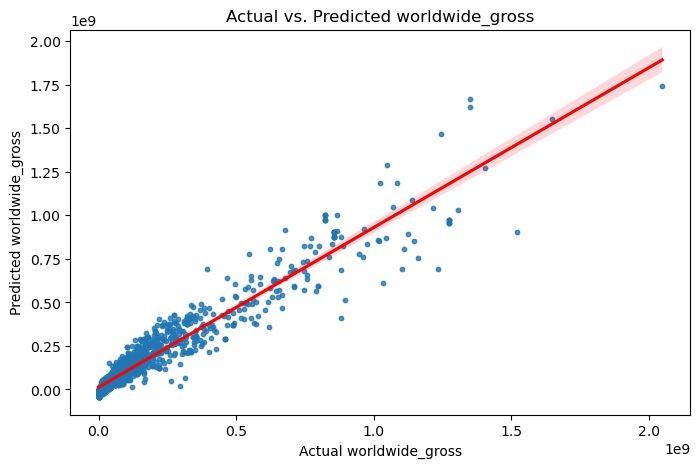

In [52]:
# 1. Linearity
# Plotting actual vs. predicted to check for linearity
plt.figure(figsize=(8, 5))
sns.regplot(x=y, y=model.predict(X), scatter_kws={'s': 10}, line_kws={'color': 'red'})

plt.xlabel("Actual worldwide_gross")
plt.ylabel("Predicted worldwide_gross")
plt.title("Actual vs. Predicted worldwide_gross")
plt.show()

The scatter plot shows a positive linear pattern between the actual and predicted values for worldwide gross revenue, suggesting that the model has a reasonable level of accuracy in predicting the gross revenue.

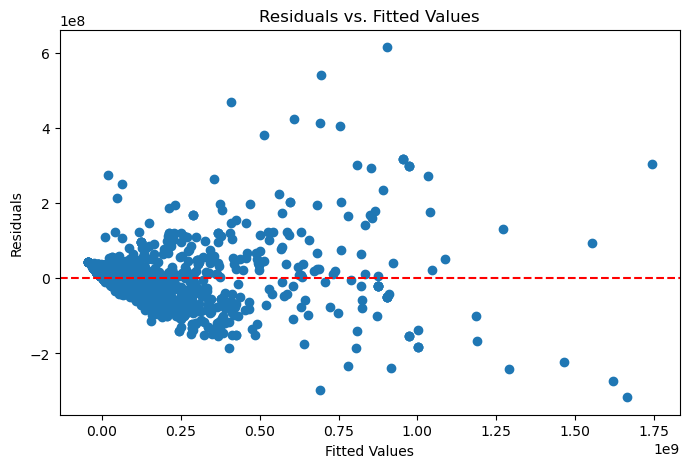

In [53]:
# 3. Homoscedasticity
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(X), model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.show()

The residuals appear unevenly distributed compared to the fitted values, indicating potential heteroscedasticity. This suggests that the variance of errors is not constant, which may impact the reliability of standard errors and hypothesis tests in this model.

<Figure size 800x500 with 0 Axes>

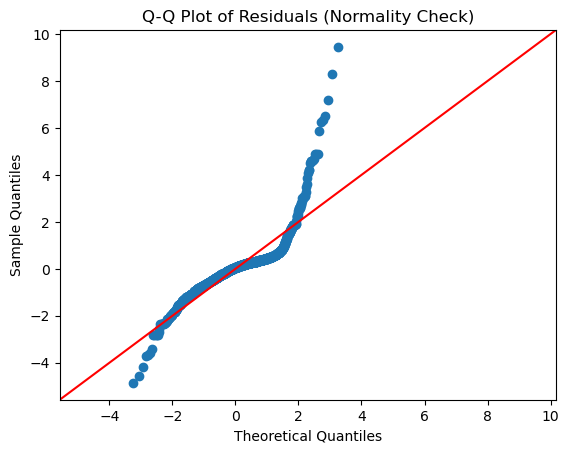

In [54]:
# 4. Normality of Errors (Q-Q plot and Shapiro-Wilk Test)
# Q-Q Plot
plt.figure(figsize=(8, 5))
sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.show()

From the Q-Q Plot above the residuals deviate significantly from the red line indicating that the residuals do not follow a normal distribution.

In [55]:
# Shapiro-Wilk Test for normality of residuals
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk Test: W={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3f}')

Shapiro-Wilk Test: W=0.800, p-value=0.000


H0 : The data follows a normal Distribution

H1 : The data does not follow a normal distribution

From the Shapiro Wilk test p-value, the p-value < 0.05 hence we reject the null hypothesis thus the data does not follow a normal distribution.

In [56]:
# 5. Multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Variable        VIF
0              const  34.238323
1         popularity   1.545269
2       vote_average   1.113848
3  production_budget   2.134383
4   domestic_gross_y   2.022219


In [57]:
conn.close()

In [58]:
# Delete the large file 

import os

# Specify the path to the file you want to delete
file_path = 'im.db'

# Check if the file exists before attempting to delete
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")

im.db has been deleted.
